# Pets data and convolutional neural networks

In this notebook, we will check another type of **regularization** which `data Augmentation`. This is least well studied types of regularization.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
# batch size
bs = 64

Lets grab the link to the **PETS** dataset

In [3]:
path = untar_data(URLs.PETS)/'images'

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

For more details about a list of transorms, I will write a separated notebook [link](https://docs.fast.ai/vision.transform.html)

In [5]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [6]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [7]:
data = get_data(224, bs, 'zeros')

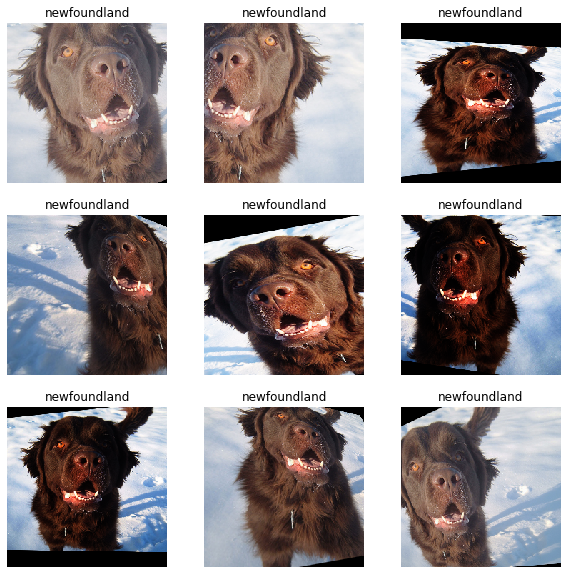

In [8]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(10,10))

## Training a model

In [9]:
gc.collect()             # full collection for the carbage collection
learner = cnn_learner(data, models.resnet34\
                     ,metrics = error_rate, bn_final=True)

In [10]:
learner.fit_one_cycle(3, slice(1e-2),pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.568132,1.423751,0.330176,01:10
1,1.554993,0.356704,0.085250,00:28
2,0.934553,0.288790,0.077131,00:29


In [11]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(1e-6,1e-3),pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.713370,0.307085,0.066982,00:34
1,0.658913,0.302727,0.070365,00:34


Let's do more training but on a small dataset. This is to illustrate that we easely change the data for a `Learner`

In [12]:
data = get_data(352, bs)
learner.data = data

In [13]:
learner.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.625686,0.288887,0.060217,01:19
1,0.604797,0.281766,0.062246,01:17


In [14]:
learner.save("stage-1")

## Convolutional Kernel

In [15]:
data= get_data(352,16)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
american_bulldog,shiba_inu,keeshond,newfoundland,english_setter
Path: /home/anass/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352),Image (3, 352, 352)
y: CategoryList
basset_hound,leonberger,shiba_inu,Persian,Siamese
Path: /home/anass/.fastai/data/oxford-iiit-pet/images;

Test: None

In [16]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate\
                     ,bn_final=True)

Letshow a simple image of the dataset

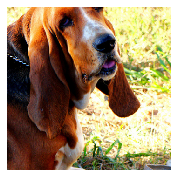

In [22]:
idx = 0
x, y = data.valid_ds[idx]
x.show()

Let apply a simple **convolution** to this iamge. We will create a custom `kernel` and compute the `conv2d` for this kernel.

We will create a simple **2D** kernel and *expand* it with the efficient method `expand` which create a smart copy without storing all the data for the tensor

In [25]:
kernel = tensor([
    [0., -5/3, 1],
    [-5/3, -5/3, 1],
    [1., 1. , 1]
]).expand(1,3,3,3)/6
kernel.shape

torch.Size([1, 3, 3, 3])

Lets grap one simple image from the dataset

In [30]:
simple_image = data.valid_ds[0][0].data
simple_image.shape

torch.Size([3, 352, 352])

Generally **pytorch** operates on *batches*, so we need to transform the data into a 4d tensor. A cool trick is to add the **None** argument

In [34]:
simple_image[None].shape

torch.Size([1, 3, 352, 352])

In [36]:
edges= F.conv2d(simple_image[None], kernel)

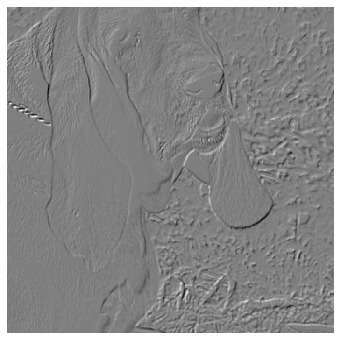

In [41]:
show_image(edges[0],figsize=(6,6))

## HeatMaps

This is an intersting features as we try to check the *saliency map* by investegating the last layer. 

In order to achieve this, we will learn about pytorch **hooks**

In [43]:
# Set the learner in evaluation mode
m = learner.model.eval()

In [47]:
#creating a data for one image
xb, _  = data.one_item(x)              # get one image
xb_im  = Image(data.denorm(xb)[0])   #remove normalization
xb = xb.cuda()                       #transform to cuda

In [48]:
from fastai.callbacks.hooks import *

In [51]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:    #hook for scores
        with hook_output(m[0],grad = True) as hook_g:   # hook for gradient
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [52]:
hook_a, hook_g = hooked_backward()

In [53]:
#getting the actions
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [56]:
#taking the average
avg_acts = acts.mean(dim=0)
avg_acts.shape

torch.Size([11, 11])

In [54]:
#function to show the heat map
def show_heatmap(hm):
    _, ax =  plt.subplots()
    xb_im.show(ax)   # showing the image
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0)\
              ,interpolation='bilinear', cmap='magma')

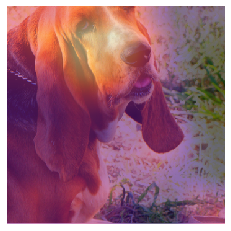

In [57]:
show_heatmap(avg_acts)

That is really cool, we could see the **focused** region for the dog

# Grad-CAM

Let's now visualize the features but according to the gradient, we already hooked on the grad with `grad_g` so we could visualize the gradient

In [58]:
grad  = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)

In [60]:
grad.shape, grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

Lets perform a step of gradient ascent 

In [61]:
mult = (acts*grad_chan[..., None, None]).mean(0)

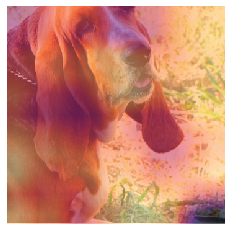

In [62]:
show_heatmap(mult)